# Boston 房价预测

数据较少，只有 506 个 sample，其中 404 个 training samples。输入数据的每个特征都有不同的取值范围。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
tf.__version__

'2.1.0'

In [3]:
# Load the data
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape, test_data.shape

((404, 13), (102, 13))

In [4]:
# 单位: 千美元
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

**<font color='crimson'>将取值范围差异很大的数据输入到 NN 中，这是有问题的。</font>** NN 可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。对于这种数据，**<font color='crimson'>普遍采用的最佳实践是对每个特征做标准化</font>**，这样得到的特征平均值为 0，标准差为 1。

In [5]:
# Standardization
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

# Same to test data
test_data -= mean
test_data /= std

由于这里的样本数量较少，所以要使用一个非常小的网络。

**<font color='crimson'>一般来说，训练数据越少，过拟合会越严重，而较小的 NN 可以降低过拟合。</font>**

In [6]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Dense(64, activation='relu',
                              input_shape=(train_data.shape[1], )))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    # Linear layer: One unit without activation for scalar regression
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

NN 最后一层只有一个 unit，且没有 activation，是一个**线性层**。这是标量回归的典型设置。

<font color='crimson'>添加 activation 将会限制输出范围。这里最后一层是纯线性的，所以 NN 可以学会预测任意范围内的值。</font>

- **均方误差 (MSE，mean squared error)** 预测值与目标值之差的平方， 回归问题的典型损失函数。


- **平均绝对误差 (MAE，mean absolute error)** 预测值与目标值之差的绝对值。

为在调节 NN 参数(如 epoch) 的同时对 NN 进行评估，可以将数据划分为训练集和验证集。但由于数据很少，验证集将会非常小。因此验证集上的 score 会有很大波动，这取决于所选择的验证集和训练集。**<font color='crimson'>数据较少时，验证集的划分方式可能会造成验证分数上有很大的方差，无法对模型进行可靠的评估。</font>** 此时，**<font color='crimson'>最佳的方法是 K-fold cv</font>**，模型的验证分数等于 K 个验证分数的平均值。

In [7]:
# K-fold cross validation
from sklearn.model_selection import KFold

K = 4
EPOCHS = 100
all_val_scores = []

# Shuffle the data before splitting into batches.
kf = KFold(n_splits=K, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(train_data, train_targets):
    x_train, x_val = train_data[train_idx], train_data[val_idx]
    y_train, y_val = train_targets[train_idx], train_targets[val_idx]

    model = build_model()
    # 0 = silent, 1 = progress bar, 2 = one line per epoch
    # verbose=2 is recommended when not running interactively (eg, in a production environment).
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
    all_val_scores.append(val_mae)


In [8]:
all_val_scores

[2.4147315, 2.3568742, 2.6902518, 2.5021925]

In [9]:
np.mean(all_val_scores)

2.4910126

In [10]:
# Save the per-epoch validation score log
tf.keras.backend.clear_session()

K = 4
EPOCHS = 500
all_mae_history = []

# Shuffle the data before splitting into batches.
kf = KFold(n_splits=K, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(train_data, train_targets):
    x_train, x_val = train_data[train_idx], train_data[val_idx]
    y_train, y_val = train_targets[train_idx], train_targets[val_idx]

    model = build_model()
    # verbose = 0, in slient mode
    history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=1,
                        validation_data=(x_val, y_val), verbose=0)
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)
    print("processed.", end='')

processed.processed.processed.processed.

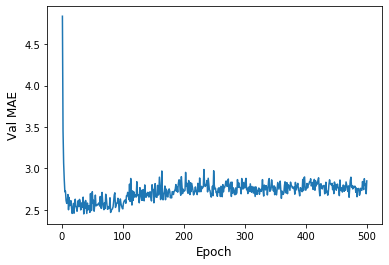

In [11]:
# Compute the average of the per-epoch MAE score for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_history])
                       for i in range(EPOCHS)]

# Plot this
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Val MAE', fontsize=12)
plt.show()

因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。

可以使用指数移动平均来重绘该图。

**<font color='red'>指数移动平均 (Exponential Moving Average, EMA)</font>** 各数值的加权按指数递减。指数移动平均实际上是一个无穷级数，即无论多久远的数据都会在计算当期的指数移动平均数值时有一定的作用，只不过离当前太远的数据权重非非常低，因此它们的作用往往可以忽略。

$$EMA_t=
\begin{cases}
y_1& \text{t = 1}\\
\alpha * y_t + (1 - \alpha) \times EMA_{t-1}& \text{t > 1}
\end{cases} 
$$

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * 0.9 + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

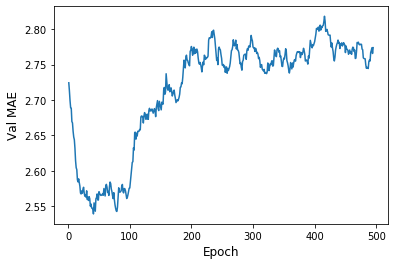

In [14]:
smooth_mae_history = smooth_curve(average_mae_history[5:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Val MAE', fontsize=12)
plt.show()

可以看出，val mae 大概在 80 之后不再显著下降，之后就开始过拟合。

**<font color='crimson'>完成模型所有调参之后，可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。</font>**

In [25]:
# Train a final "production" model on all of the training data, with the best parameters
# after tuning all parameters.
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 627us/sample - loss: 17.3674 - mae: 2.8111


[17.367375242943858, 2.8110845]

Emmm...

**<font color='crimson'>Summary:</font>**

- 回归常用的损失函数是均方误差 (MSE)


- 常见的回归指标是平均绝对误差 (MAE)


- 如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放


- 如果可用的数据很少，使用 K-Flod CV 可以可靠地评估模型


- 如果可用的训练数据很少，最好使用隐藏层较少 (通常只有一到两个)的小型 NN，以避免严重的过拟合。